# Adaptive Quantile Regression: Visualization

This notebook loads the best-trained `QuantileRegressor` model and visualizes its performance on the test set. It performs the following steps:

1.  **Load Configuration**: Reads the `config.yaml` file to ensure settings are consistent with the training run.
2.  **Load Model**: Loads the best model checkpoint saved by PyTorch Lightning.
3.  **Load Data**: Re-initializes the `PolynomialDataModule` to get access to the test dataset and the true polynomial coefficients.
4.  **Generate Predictions**: For a set of specified quantiles (e.g., 0.05, 0.50, 0.95), it uses the model to predict the corresponding `y` values for the test `x` values.
5.  **Plot Results**: Creates a comprehensive plot showing:
    * The raw test data points (as a scatter plot).
    * The true underlying polynomial function (as a dashed line).
    * The predicted quantile curves (as solid lines).

In [1]:
import torch
import pytorch_lightning as pl

import numpy as np
import yaml
import matplotlib.pyplot as plt
import glob
import os

# Import our custom modules
from src.model import QuantileRegressor
from src.data import PolynomialDataModule

### 1. Load Configuration and Find Best Checkpoint

In [2]:
# Load the configuration file
config_path = 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Find the best model checkpoint automatically
checkpoint_dir = config['training']['checkpoint_dir']
list_of_files = glob.glob(os.path.join(checkpoint_dir, '*.ckpt'))
if not list_of_files:
    raise FileNotFoundError(f"No checkpoint files found in '{checkpoint_dir}'. Please run train.py first.")

latest_file = max(list_of_files, key=os.path.getctime)
checkpoint_path = latest_file

print(f"Loaded configuration from: {config_path}")
print(f"Found best model checkpoint at: {checkpoint_path}")

Loaded configuration from: config.yaml
Found best model checkpoint at: checkpoints/best-model-epoch=106-val_loss=3.40.ckpt


### 2. Load Model and DataModule

In [ ]:
# Load the trained model from the checkpoint
model = QuantileRegressor.load_from_checkpoint(checkpoint_path)
model.eval() # Set the model to evaluation mode (disables dropout, etc.)

# Instantiate the DataModule with the same parameters used for training
# This ensures we get the same data distribution and true function
pl.seed_everything(config['seed']) # Use the same seed for reproducibility
data_module = PolynomialDataModule(
    degree=config['data']['degree'],
    noise_scale=config['data']['noise_scale'],
    n_samples=config['data']['n_samples'],
    batch_size=config['training']['batch_size'],
    x_range=config['data']['x_range'],
)

# The .setup() method generates the data and performs the train/val/test splits
data_module.setup()

# Get the test data tensors.
# NOTE: random_split creates a 'Subset' object. We must access the
# underlying .dataset and use the subset's .indices to get the correct data.
full_dataset = data_module.test_dataset.dataset
train_indices = data_module.train_dataset.indices
test_indices = data_module.test_dataset.indices

train_x = full_dataset.tensors[0][train_indices]
train_y = full_dataset.tensors[1][train_indices]
test_x = full_dataset.tensors[0][test_indices]
test_y = full_dataset.tensors[1][test_indices]

Seed set to 42


### 3. Generate Predictions and Plot Results

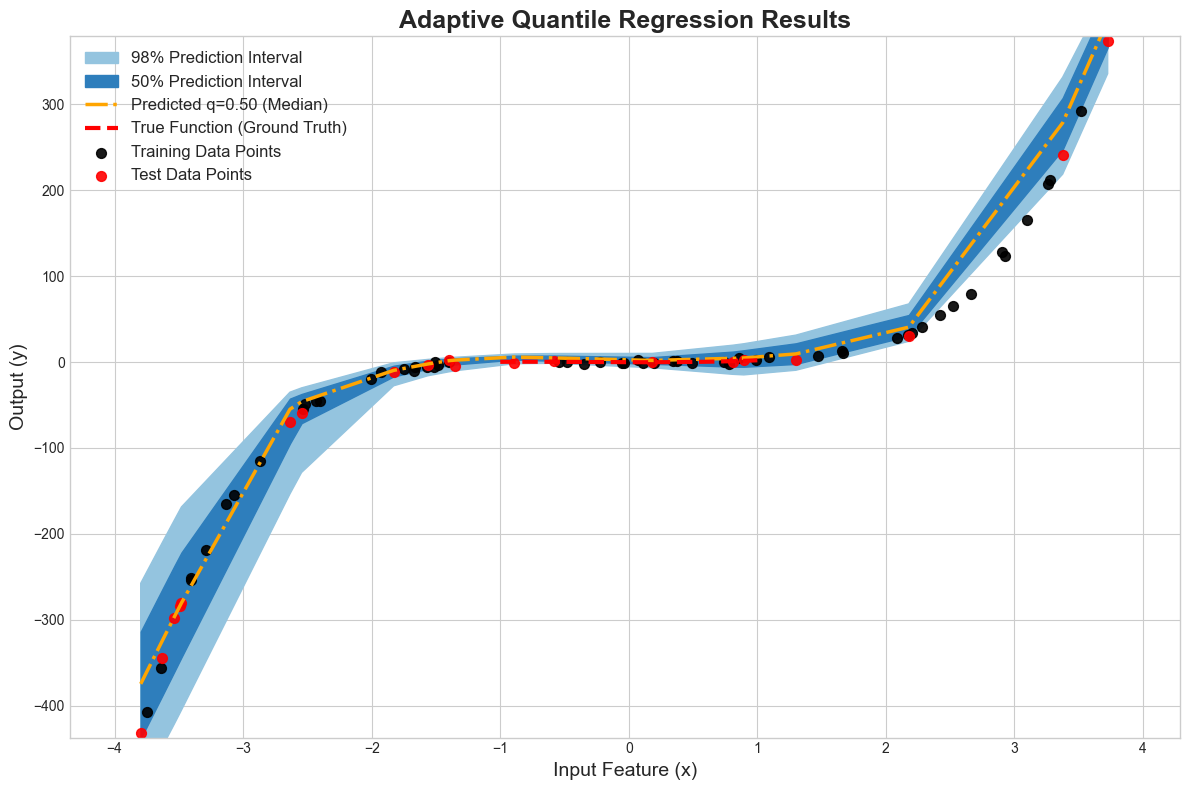

In [4]:
# Set up the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# For a clean line plot, we need to sort the x values
sorted_indices = torch.argsort(test_x.squeeze())
sorted_x = test_x[sorted_indices]

# Move data to the same device as the model (e.g., 'cuda' or 'mps')
device = model.device
sorted_x = sorted_x.to(device)

# 2. Generate and plot the predicted quantile intervals with shading
with torch.no_grad(): # Deactivate autograd for faster inference
    # --- Plot shaded uncertainty intervals ---
    intervals = [(0.25, 0.75), (0.01, 0.99)]
    # Use different shades of a color for the intervals
    colors = plt.cm.Blues(np.linspace(0.4, 0.7, len(intervals)))

    # Plot intervals from widest to narrowest
    for i, (q_low, q_high) in enumerate(reversed(intervals)):
        # Predict lower bound
        tau_low = torch.full((sorted_x.shape[0], 1), q_low, device=device)
        pred_low = model(sorted_x, tau_low)

        # Predict upper bound
        tau_high = torch.full((sorted_x.shape[0], 1), q_high, device=device)
        pred_high = model(sorted_x, tau_high)

        # Use fill_between to create the shaded region
        ax.fill_between(
            sorted_x.cpu().numpy().squeeze(),
            pred_low.cpu().numpy().squeeze(),
            pred_high.cpu().numpy().squeeze(),
            color=colors[i],
            label=f'{int((q_high - q_low) * 100)}% Prediction Interval'
        )

    # --- Plot the median prediction as a line ---
    tau_median = torch.full((sorted_x.shape[0], 1), 0.5, device=device)
    pred_median = model(sorted_x, tau_median)
    ax.plot(
        sorted_x.cpu().numpy(),
        pred_median.cpu().numpy(),
        label='Predicted q=0.50 (Median)',
        color='orange',
        linewidth=2.5,
        linestyle='-.'
    )

# 3. Plot the true underlying function (without noise)
x_range = config['data']['x_range']
true_x_line = np.linspace(x_range[0], x_range[1], 400)
true_y_line = np.polyval(data_module.coeffs, true_x_line)
ax.plot(true_x_line, true_y_line, color='red', linestyle='--', linewidth=3, label='True Function (Ground Truth)')

# 1. Plot the raw training and test data points
ax.scatter(
    train_x.cpu().numpy(),
    train_y.cpu().numpy(),
    alpha=0.9, label='Training Data Points', color='black', s=50
)
ax.scatter(
    test_x.cpu().numpy(),
    test_y.cpu().numpy(),
    alpha=0.9, label='Test Data Points', color='red', s=50
)

# Final plot styling
ax.set_title('Adaptive Quantile Regression Results', fontsize=18, fontweight='bold')
ax.set_xlabel('Input Feature (x)', fontsize=14)
ax.set_ylabel('Output (y)', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylim(test_y.cpu().numpy().min() - 5, test_y.cpu().numpy().max() + 5) # Adjust y-limits for better visibility
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>